In [1]:
# Coursework for IIP Task2
# Junyu Liu 20216355

In [2]:
#--- Import libraries ---#
from __future__ import print_function
from multiprocessing.pool import ThreadPool

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import random

In [3]:
#--- Customized filters / image processing techniques ---#
#--- Adjust gamma level ---#
# modified from the reference: https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
def adjust_gamma(imgs, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    new_imgs = np.zeros_like(imgs)
    for i in range(imgs.shape[0]):
        for j in range(imgs.shape[1]):
            new_imgs[i, j] = cv2.LUT(np.array(imgs[i, j], dtype=np.uint8), table)
    return new_imgs

#--- Build Gaussian matched filters ---#
# modified from the reference: https://blog.csdn.net/qq_40511157/article/details/102770108?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164916485916780264050983%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=164916485916780264050983&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-6-102770108.142^v5^pc_search_result_cache,157^v4^control&utm_term=%E6%B8%85%E9%A3%8E_1998&spm=1018.2226.3001.4187
def build_match_filters(sigma=1, YLength=10):
    filters = []
    widthOfTheKernel = np.ceil(np.sqrt((6 * np.ceil(sigma) + 1) ** 2 + YLength ** 2))
    
    # Calculate the width of kernel
    if np.mod(widthOfTheKernel, 2) == 0:
        widthOfTheKernel = widthOfTheKernel + 1
    widthOfTheKernel = int(widthOfTheKernel)
    
    # Rotate around 12 directions with corresponding width
    for theta in np.arange(0, np.pi, np.pi / 16):
        matchFilterKernel = np.zeros((widthOfTheKernel, widthOfTheKernel), dtype=np.float)
        for x in range(widthOfTheKernel):
            for y in range(widthOfTheKernel):
                halfLength = (widthOfTheKernel - 1) / 2
                x_ = (x - halfLength) * np.cos(theta) + (y - halfLength) * np.sin(theta)
                y_ = -(x - halfLength) * np.sin(theta) + (y - halfLength) * np.cos(theta)
                if abs(x_) > 3 * np.ceil(sigma):
                    matchFilterKernel[x][y] = 0
                elif abs(y_) > (YLength - 1) / 2:
                    matchFilterKernel[x][y] = 0
                else:
                    matchFilterKernel[x][y] = -np.exp(-.5 * (x_ / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)
        m = 0.0
        for i in range(matchFilterKernel.shape[0]):
            for j in range(matchFilterKernel.shape[1]):
                if matchFilterKernel[i][j] < 0:
                    m = m + 1
        mean = np.sum(matchFilterKernel) / m
        for i in range(matchFilterKernel.shape[0]):
            for j in range(matchFilterKernel.shape[1]):
                if matchFilterKernel[i][j] < 0:
                    matchFilterKernel[i][j] = matchFilterKernel[i][j] - mean
        filters.append(matchFilterKernel)

    return filters

#--- Add filters on the image ---#
# modified from the reference: https://blog.csdn.net/qq_40511157/article/details/102770108?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164916485916780264050983%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=164916485916780264050983&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-6-102770108.142^v5^pc_search_result_cache,157^v4^control&utm_term=%E6%B8%85%E9%A3%8E_1998&spm=1018.2226.3001.4187
def add_filters(img, filters):
    accum = np.zeros_like(img)
    for kernel in filters:
        fimg = cv2.filter2D(img, cv2.CV_8U, kernel, borderType=cv2.BORDER_REPLICATE)
        np.maximum(accum, fimg, accum)
    return accum

#--- Gray strech a certain intensity range of image ---#
# modified from the reference: https://blog.csdn.net/qq_40511157/article/details/102770108?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164916485916780264050983%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=164916485916780264050983&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-6-102770108.142^v5^pc_search_result_cache,157^v4^control&utm_term=%E6%B8%85%E9%A3%8E_1998&spm=1018.2226.3001.4187
def gray_stretch(img, m=60.0/255, e=8.0):
    k = np.zeros(img.shape, np.float)
    ans = np.zeros(img.shape, np.float)
    mx = np.max(img)
    mn = np.min(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            k[i][j] = (float(img[i][j]) - mn) / (mx - mn)
    eps = 0.01
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ans[i][j] = 1 / (1 + (m / (k[i][j] + eps)) ** e) * 255
    ans = np.array(ans, np.uint8)
    return ans

#--- Apply double threshold on the image ---#
# modified from the reference: https://theailearner.com/tag/hysteresis-thresholding/
def double_threshold(img, lowThreshold, highThreshold):
    highThreshold = 80
    lowThreshold = 30

    M, N = img.shape
    out = np.zeros((M,N), dtype= np.uint8)
 
    # If edge intensity is greater than 'High' it is a sure-edge
    # below 'low' threshold, it is a sure non-edge
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
 
    # Separate weak edges
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    # Set same intensity value for all edge pixels
    out[strong_i, strong_j] = 255
    out[zeros_i, zeros_j ] = 0
    out[weak_i, weak_j] = 30
    
    # Apply threshold to separate the values to 0 and 255
    M, N = out.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (out[i,j] == 75):
                if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                    out[i, j] = 255
                else:
                    out[i, j] = 0
                    
    return out

In [4]:
#--- Processing the image ---#
def imgProcess(img, mask):
    # Step1 - Separate the green channel since it shows clearest vessels
    #       - Separate the grey scale of mask
    img_green = img[:,:,1]
    mask = mask[:,:,0]
    
    # Step2 - Add gaussian blur
    # OpenCV built-in Gaussian blur filter is used.
    img_blur = cv2.GaussianBlur(img_green, (5, 5), 0)
    
    # Step3 - Mitigate the un-even lighting and boost the contrast
    # OpenCV built-in Contrast Limited Adaptive Histogram Equalization (CLAHE) method is used.
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(10, 10))
    img_clache = clahe.apply(img_blur)
    
    # Step 4 - Adjust the gamma level to a reasonable brightness
    # Customized gamma correction function is used.
    img_gamma = adjust_gamma(img_clache, gamma=2.0)
    
    # Step 5 - Apply Gaussian matched filter to extract the textures from vessels
    # Customized Gaussian matched filter function is used.
    match_filters = build_match_filters()
    img_match = add_filters(img_gamma, match_filters)
    
    # Step6 - Mask out the background
    # Example method provided with coursework is used.
    img_mask = np.multiply(img_match, mask/255)
    image_mask_unify = np.array(img_mask, dtype='uint8')
    
    # Step7 - Apply gray stretch on the image to highlight the vessels
    # Custimized gray stretch function is used.
    img_grayStretch = gray_stretch(image_mask_unify, m=30 / 255, e=10)
    
    # Step8 - Apply double threshold on the image to recover some tiny vessels
    # Customized double threshold function is used.
    img_hyTreshold = double_threshold(img_grayStretch, 30, 80)
    
    # Step9 - Apply morphology close calculation to connect tiny holes
    # OpenCV built-in morphology close calculation is used.
    kernel = np.ones((3, 3), dtype=np.uint8)
    img_close = cv2.morphologyEx(img_hyTreshold, cv2.MORPH_CLOSE, kernel)
    
    # Get the final image
    img_final = img_close.copy()
    
    return img_final   

In [5]:
#--- Calculate the prediction accuracy ---#
def calculateAccuracy(label, predictImg, mask):
    #--- Process image for calculation ---#
    mask = mask[:,:,0]
    predictImg = predictImg / 255
    
    #--- Calculate TP, TN, FP, FN, P, N, T respectively ---#
    TP = sum(sum((label==255) & (predictImg==1) & (mask == 255)))
    TN = sum(sum((label==0) & (predictImg==0) & (mask == 255)))
    FP = sum(sum((label==0) & (predictImg==1) & (mask == 255)))
    FN = sum(sum((label==255) & (predictImg==0) & (mask == 255)))
    P = TP/(TP+FN)
    N = TN/(TN+FP)
    T = (TP+TN)/(TP+FN+TN+FP)
    
    #--- Print the results ---#
    print("T of processed image is " + str(T))
    print("[TP,TN,FP,FN] are " + str([TP, TN, FP, FN]) + " respectively")

In [6]:
#--- Show comparisons of the ground truth image and the predicted image ---#
def showComparison(label, img_final):
    plt.figure(figsize = (15,15))
    plt.subplot(121), plt.imshow(label,cmap='gray', vmin=0, vmax=255), plt.title('Ground Truth Image')
    plt.subplot(122), plt.imshow(img_final,cmap='gray', vmin=0, vmax=255), plt.title('Processed Image')
    
    #--- Save the processed image ---#
    # Note that the url might be different on different computers, thus this line may need to be changed.
    cv2.imwrite('./results/segmentated_image.png', img_final)

In [7]:
#--- Main function to call all processing functions ---#
random.seed(0)
def main():
    #--- Specify the image reading path ---#
    path = 'Task2_images'
    
    #--- Read images ---#
    img = cv2.imread(os.path.join(path,'retina.tif'),cv2.IMREAD_COLOR)
    mask = cv2.imread(os.path.join(path,'Mask.png'),cv2.IMREAD_COLOR)
    label = cv2.imread(os.path.join(path,'Label.png'),cv2.IMREAD_GRAYSCALE)
    
    #--- Process images ---#
    img_final = imgProcess(img, mask)
    
    #--- Calculate the accuracy of the predicted image ---#
    calculateAccuracy(label, img_final, mask)
    
    #--- Show comparison of the ground truth image and the predicted image ---#
    showComparison(label, img_final)

T of processed image is 0.9530710395442694
[TP,TN,FP,FN] are [22856, 186609, 5294, 5020] respectively


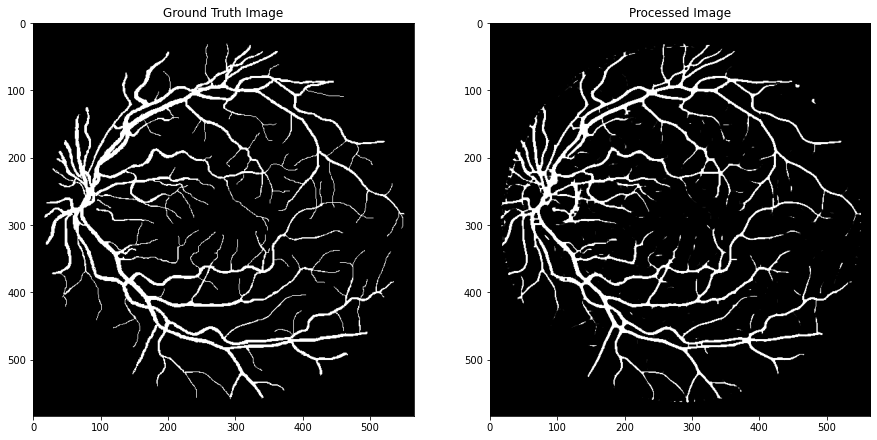

In [8]:
if __name__ == '__main__':
    main()